# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import shap
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.under_sampling import RandomUnderSampler

# 2. Definições

In [2]:
IMAGES_PATH = "../reports/figures/"
PATH_INPUT_DATASET = "../data/processed/internacoes_processado.csv"
PATH_BEST_MODELS = "./models/best_models.pkl"

style_dict = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlesize": "large",
    'text.color': '.25',
}

sns.set_theme(
    context="paper",
    style="ticks",
    palette="hls",
    rc=style_dict
)

validacao_metrica_mapping = {
    'Acurácia' : 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Precisão': 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Recall': 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'AUC': 'Sem Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Acurácia_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Precisão_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Recall_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'AUC_Tunagem': 'Com Tunagem de Hiper-parâmetros\n(dataset de treino)',
    'Acurácia_Teste': 'Houldout dataset',
    'Precisão_Teste': 'Houldout dataset',
    'Recall_Teste': 'Houldout dataset',
    'AUC_Teste': 'Houldout dataset'
}

class CyclicalDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name, period):
        self.column_name = column_name
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column_name + '_sin'] = np.sin(2 * np.pi * X[self.column_name] / self.period)
        X_copy[self.column_name + '_cos'] = np.cos(2 * np.pi * X[self.column_name] / self.period)
        X_copy = X_copy.drop(self.column_name, axis=1)
        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        feature_names_out = [self.column_name + '_sin', self.column_name + '_cos']
        return feature_names_out

# 3. Funções de apoio

In [3]:
def salvar_figura(fig, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH + f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    print(f'Salvando figura {fig_id}...')
    fig.savefig(path, format=fig_extension, dpi=resolution)

def obter_nomes_colunas_por_tipo(df, numeric=False):
    if numeric:
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    else:
        return list(df.select_dtypes(include=['object']).columns)

def plotar_features_categoricas(df, target_column, categorical_features):
    for feature in categorical_features:
        sns.countplot(x=feature, data=df, hue=target_column)
        plt.show()
        plt.clf()
    plt.tight_layout()

def melt_results_df(results_df):
    df = pd.melt(results_df, id_vars="Model", value_vars=results_df.columns[1:])
    
    df['Validacao'] = df['variable'].map(validacao_metrica_mapping)
    df['Metrica'] = df['variable'].str.split('_').str[0]
    df['Valor'] = df['value']

    df = df.drop(columns=['variable', 'value'])

    return df
    

# 4. Validação

In [4]:
input = pd.read_csv('model_selection_results.csv')
results = melt_results_df(input)

results

,Model,Validacao,Metrica,Valor
0,RandomForest,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.534426
1,GradientBoosting,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.555738
2,LogisticRegression,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.559426
3,XGB,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.534426
4,LGBM,Sem Tunagem de Hiper-parâmetros\n(dataset de t...,Acurácia,0.539754
...,...,...,...,...
79,LogisticRegression,Houldout dataset,AUC,0.532521
80,XGB,Houldout dataset,AUC,0.554218
81,LGBM,Houldout dataset,AUC,0.551911
82,SVM,Houldout dataset,AUC,0.522835


Salvando figura comparacao_metricas_por_modelo...


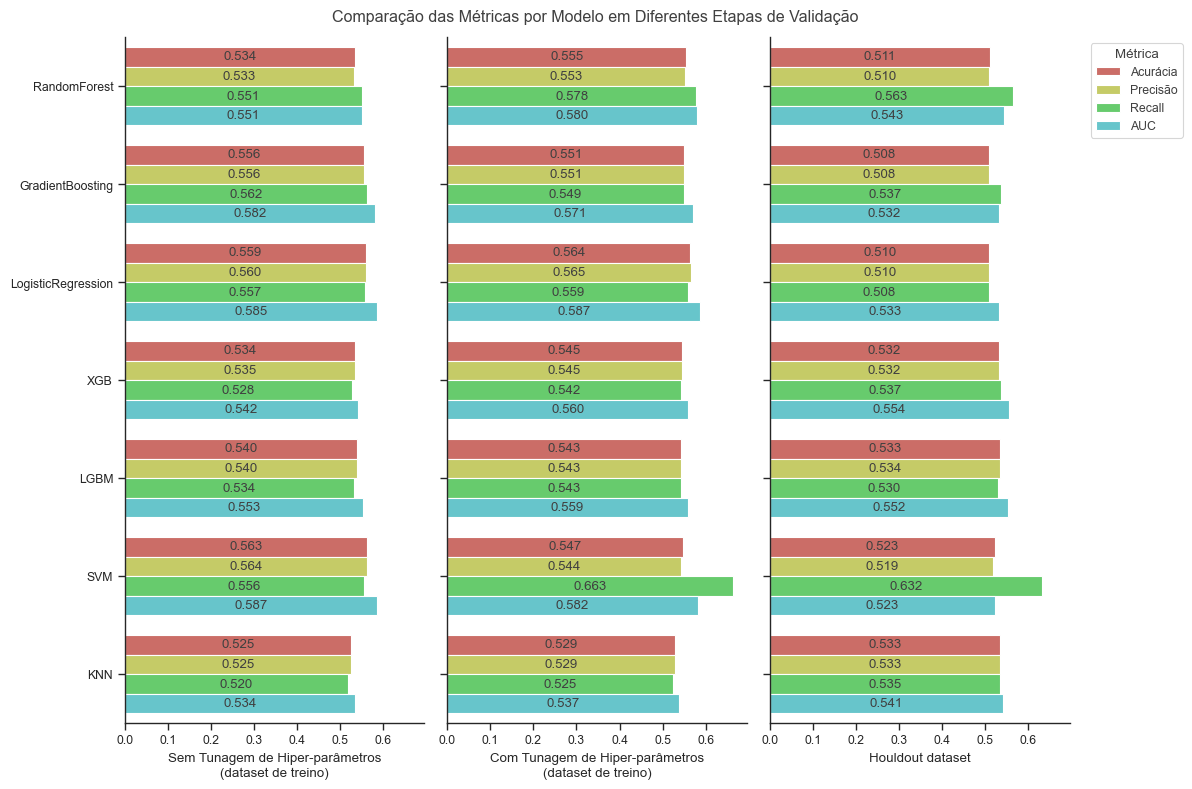

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for tipo_validacao, ax in zip(results["Validacao"].unique(), axes):

    to_plot = results[results["Validacao"] == tipo_validacao]
    
    bars = sns.barplot(x="Valor", y="Model", hue="Metrica", data=to_plot, ax=ax, ci=95, orient='h')
    ax.set_xlabel(tipo_validacao)
    ax.set_ylabel("")
    ax.legend().remove()

    for bar in bars.patches:
        width = bar.get_width()
        ax.text(width / 2, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', ha='center', va='center')


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Métrica");

fig.suptitle("Comparação das Métricas por Modelo em Diferentes Etapas de Validação")
salvar_figura(fig, "comparacao_metricas_por_modelo")

Salvando figura variacao_metricas_teste_por_modelo...


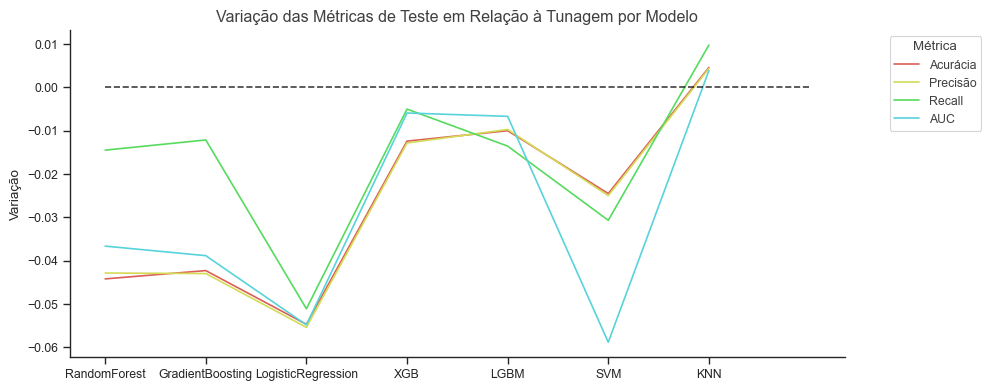

In [81]:
metricas = [
    "Acurácia",
    "Precisão",
    "Recall",
    "AUC"
]

for metrica in metricas:
    input[metrica] = (input[f'{metrica}_Teste'] - input[f'{metrica}_Tunagem'])

melted = pd.melt(input, id_vars=['Model'], value_vars=[metrica for metrica in metricas], value_name="Valor", var_name="Métrica")

fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(data=melted, x='Model', y='Valor', hue='Métrica', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Métrica')
ax.set_ylabel('Variação')
ax.set_xlabel('')
ax.plot([0, len(input['Model'].unique())], [0, 0], color='black', alpha=0.75, linestyle='--')
ax.set_title("Variação das Métricas de Teste em Relação à Tunagem por Modelo");

salvar_figura(fig, "variacao_metricas_teste_por_modelo")

Salvando figura variacao_pct_metricas_teste_por_modelo...


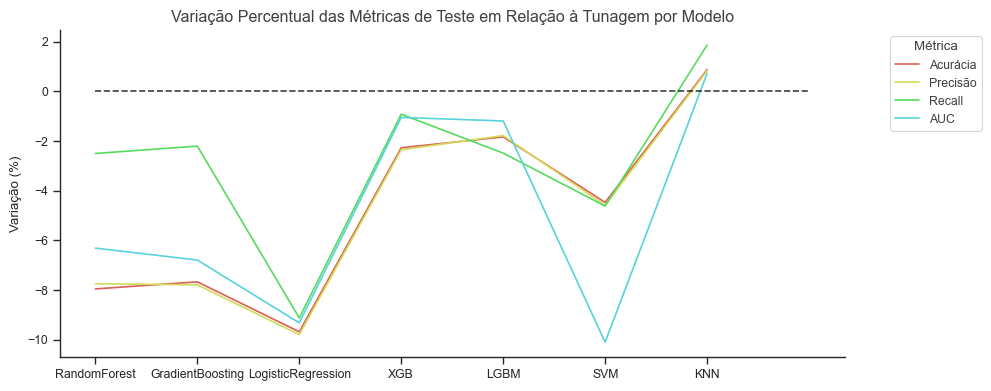

In [82]:
metricas = [
    "Acurácia",
    "Precisão",
    "Recall",
    "AUC"
]

for metrica in metricas:
    input[metrica] = (input[f'{metrica}_Teste'] / input[f'{metrica}_Tunagem'] - 1) * 100

melted = pd.melt(input, id_vars=['Model'], value_vars=[metrica for metrica in metricas], value_name="Valor", var_name="Métrica")

fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(data=melted, x='Model', y='Valor', hue='Métrica', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Métrica')
ax.set_ylabel('Variação (%)')
ax.set_xlabel('')
ax.plot([0, len(input['Model'].unique())], [0, 0], color='black', alpha=0.75, linestyle='--')
ax.set_title("Variação Percentual das Métricas de Teste em Relação à Tunagem por Modelo");

salvar_figura(fig, "variacao_pct_metricas_teste_por_modelo")

# 5. Análise de Feature Importance

In [83]:
with open(PATH_BEST_MODELS, 'rb') as f:
    best_models = pickle.load(f)

preprocessor = best_models['LGBM']['preprocessor']
model = best_models['LGBM']['model']

df = pd.read_csv(PATH_INPUT_DATASET)

X = df.drop("reinternacao", axis=1)
y = df["reinternacao"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)

X_train_resampled = preprocessor.transform(X_train_resampled).toarray()
X_test_resampled = preprocessor.transform(X_test_resampled).toarray()

features_names = [name.split("__")[-1] for name in preprocessor.get_feature_names_out()]

In [84]:
explainer = shap.Explainer(model, X_train_resampled, feature_names=features_names)
shap_values = explainer.shap_values(X_test_resampled, check_additivity=False)

Salvando figura top-features-lgbm...


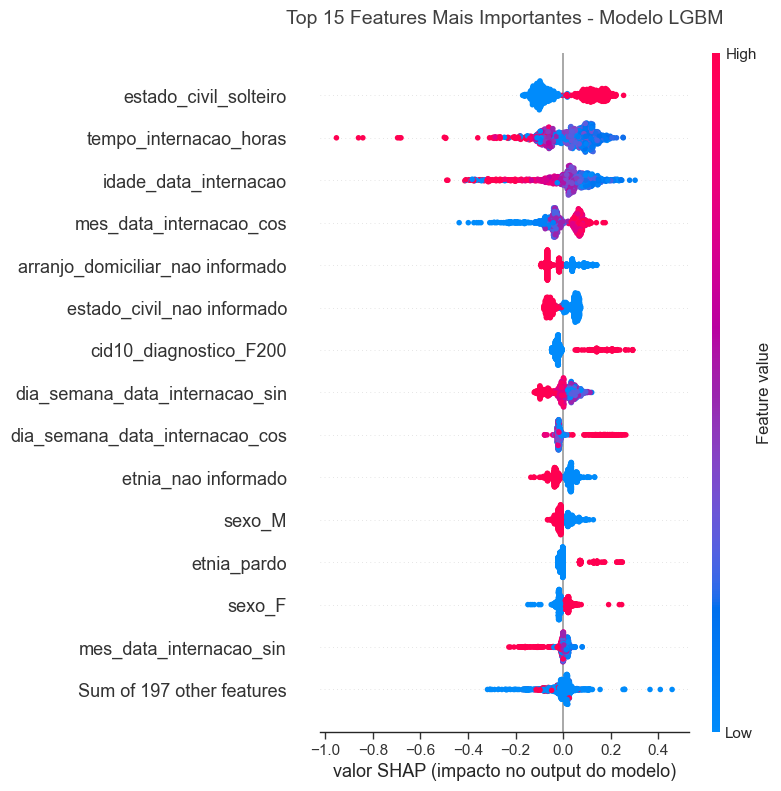

In [85]:
n_top_features = 15

shap.plots.beeswarm(
    shap.Explanation(
        values=shap_values,
        feature_names=features_names,
        data=X_test_resampled
    ),
    max_display=n_top_features,
    show=False,
    plot_size=(8, 8)
)

fig = plt.gcf()
ax = plt.gca()

ax.set_xlabel('valor SHAP (impacto no output do modelo)')
ax.set_title(f'Top {n_top_features} Features Mais Importantes - Modelo LGBM\n', fontsize=14);

salvar_figura(fig, 'top-features-lgbm')